In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import torch
import matplotlib.pyplot as plt

In [6]:
path = "/Users/abhishekpatnaik/Downloads/quora-question-pairs/train.csv"

In [7]:
df = pd.read_csv(path)

In [4]:
df.tail()

In [8]:
idx = 404286
print(df.question1.loc[idx],df.question2.loc[idx])

Do you believe there is life after death? Is it true that there is life after death?


In [16]:
# lets see how duplicate questions looks like
duplicate = df[df['is_duplicate'] == 1] 

In [17]:
duplicate = duplicate.reset_index()
duplicate.head(5)

,index,id,qid1,qid2,question1,question2,is_duplicate
0,5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [18]:
idx = 5
print(duplicate.question1.loc[idx],duplicate.question2.loc[idx])

What would a Trump presidency mean for current international master’s students on an F1 visa? How will a Trump presidency affect the students presently in US or planning to study in US?


In [19]:
# Now lets see how different questions looks like
diff = df[df['is_duplicate'] == 0]
diff = diff.reset_index()

In [20]:
diff.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
idx = 10
print(diff.question1.loc[idx],diff.question2.loc[idx])

In [ ]:
# the very first method that came to my mind was sentence similarity


In [ ]:
from gensim.models import Word2Vec

In [ ]:
tokenized_sentences1 = diff.question1.loc[10].split()
tokenized_sentences2 = diff.question2.loc[10].split()
model1 = Word2Vec(tokenized_sentences1,min_count=1)
model2 = Word2Vec(tokenized_sentences2,min_count=1)

In [ ]:
tokenized_sentences1, tokenized_sentences2

In [ ]:
def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return 0.0
        else:
            return float(numerator) / denominator

def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words        

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
model =  KeyedVectors.load_word2vec_format('/Users/abhishekpatnaik/Downloads/GoogleNews-vectors-negative300.bin', binary=True)


In [ ]:
from nltk.corpus import stopwords
import nltk
stop_words = set(stopwords.words('english')) 
#filtered_sentence = [w for w in tokenized_sentences1 if not w in stop_words]
list_1 = [[x for x in review_to_wordlist(duplicate.question1.loc[13]) if x not in stop_words]]
list_2 = [[x for x in review_to_wordlist(duplicate.question2.loc[13]) if x not in stop_words]]
print(list_1)
vectors1 = [model[w] for w in list_1]
vectors2 = [model[w] for w in list_2]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cos_lib = cosine_similarity(vectors1[0], vectors2[0])

In [ ]:
print(list_1,list_2)
cos_lib[0][0]

In [ ]:
from gensim.similarities import WmdSimilarity

In [ ]:
model.wmdistance(diff.question1.loc[4].split(" "), diff.question2.loc[4].split(" "))

In [ ]:
duplicate.question1.loc[10].split(" "),duplicate.question2.loc[10].split(" ")

In [ ]:
from gensim.models import Word2Vec, word2vec

In [ ]:
question1 = [review_to_wordlist(str(x)) for x in df.question1]

In [ ]:
question2 = [review_to_wordlist(str(x)) for x in df.question2]

In [ ]:
label = [x for x in df.is_duplicate]

In [ ]:
len(label)

In [ ]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3
model = word2vec.Word2Vec(question1+question2, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

In [ ]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

In [ ]:
# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in df.question1:
    clean_train_reviews.append(review_to_wordlist(str(review), remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)


In [ ]:
# infersent


In [ ]:
mkdir encoder

In [ ]:
# trained on Glove
# Run only if there's no infersent encoder

In [ ]:
! curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

In [ ]:
# trained on fasttext

In [ ]:
mkdir fasttext

In [ ]:
! curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhishekpatnaik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
from models import InferSent

In [11]:
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [12]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [13]:
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [ ]:
mkdir fastText

In [ ]:
! curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip    

In [ ]:
! unzip fastText/crawl-300d-2M.vec.zip -d fastText/

In [39]:
sentences = []
for idx,ele in df.iterrows():
        sentences.append(str(ele['question1']))
  #      sentences.append(str(ele['question2']))

In [ ]:
sentences

In [ ]:
embeddings = model.encode(sentences[:1000], bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))


In [ ]:
# np.linalg.norm(model.encode(['the cat eats.']))

In [14]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


In [28]:
x = []
y = []
for i in range(100):
    idx = i
    
    x.append(cosine(model.encode([diff.question1.loc[idx]])[0], model.encode([diff.question2.loc[idx]])[0]))
    y.append(cosine(model.encode([duplicate.question1.loc[idx]])[0], model.encode([duplicate.question2.loc[idx]])[0]))
    

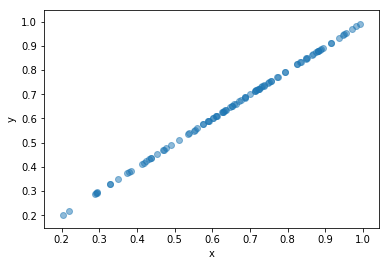

In [37]:
plt.scatter(x,x,alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

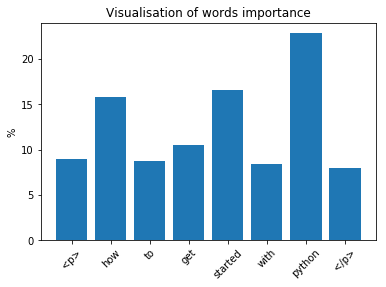

In [45]:
_, _ = model.visualize('how to get started with python')

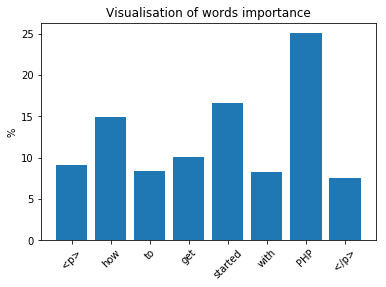

In [44]:
_, _ = model.visualize('how to get started with PHP')

In [68]:
idx=20
print(duplicate.question1.loc[idx],duplicate.question2.loc[idx])
cosine(model.encode([duplicate.question1.loc[idx]])[0], model.encode([duplicate.question2.loc[idx]])[0])

What is Java programming? How To Learn Java Programming Language ? How do I learn a computer language like java?


0.67294335

In [69]:
# unsupervised way for classification

In [90]:
similarity_score = []
question1 = []
question2 = []
answer = []
for idx in range(len(df)):
    if idx <= 2000:
        question1.append(df.question1.loc[idx])
        question2.append(df.question2.loc[idx])
        answer.append(df.is_duplicate.loc[idx])
        if (cosine(model.encode([df.question1.loc[idx]])[0], model.encode([df.question2.loc[idx]])[0])) > 78:
            similarity_score.apppend("1")
        else:
            similarity_score.append("0")

In [91]:
dataframe_score = pd.DataFrame({"similarity_score":similarity_score,"question1":question1,"question2":question2,"answer":answer})

In [92]:
dataframe_score.to_csv("without_training_word_vector.csv",index=False)

In [93]:
score = []
count = 0
for i in range(len(dataframe_score)):
        if str(dataframe_score['answer'].loc[i]) == dataframe_score['similarity_score'].loc[i]:
            count+=1

In [95]:
count/2000

0.6295